In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage
import cv2
from IPython.display import Image
from io import BytesIO
import os
import math

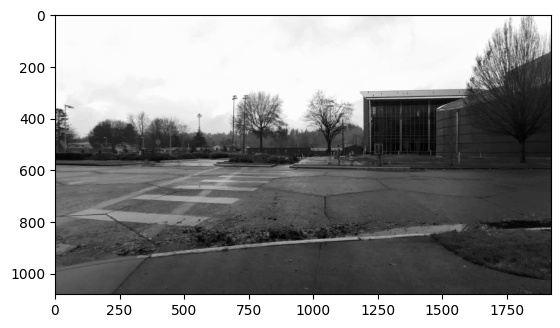

In [141]:
vc = cv2.VideoCapture('dataset/crosswalk.avi')
_, first_frame = vc.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
plt.imshow(first_frame, cmap='gray')

In [62]:
def applyOpening(img, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))):
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)

def applyClose(img, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)

def applyDilate(img, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))):
    return cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel, iterations=1)

def applyErode(img, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))):
    return cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel, iterations=1)

def findFilterContours(img, min_area=2000):
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return [contour for contour in contours if cv2.contourArea(contour) > min_area]

# Set up gif parameters
gif_length = 18
start_capturing_gif_position = 250

## Sparse flow
In this section, we will use the Lucas-Kanade method to calculate the optical flow between two frames. The Lucas-Kanade method calculates the optical flow for each feature point. The feature points are calculated using the Shi-Tomasi corner detector. The function takes the previous frame, the current frame, and the feature points from the previous frame as input. It returns the feature points in the current frame, a status vector, and an error vector. The status vector indicates whether the feature point was found in the current frame or not. The error vector indicates the error in the feature point location.

We experimented with different parameters for the Shi-Tomasi corner detector and the Lucas-Kanade method. We tried binary search to find the optimal parameters. We found that the parameters very close to default ones work best.

In [65]:
# input and output file paths
input_file_path = "dataset/crosswalk.avi"
output_file_path = "outputs/sparse.avi"
gif_file_path = "outputs/sparse.gif"

# parameters for optical flow calculation
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# read input video file
cap = cv2.VideoCapture(input_file_path)

# create VideoWriter object for output video file
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter(output_file_path, fourcc, fps, (frame_width, frame_height))

# Gif
gif_frames = []
video_frame_position = 0

# initialize frame and feature points
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
mask = np.zeros_like(prev_frame)

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break
    # convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_pts, None, **lk_params)

    # select good points
    good_next_pts = next_pts[status == 1]
    good_prev_pts = prev_pts[status == 1]

    # draw tracks and points
    for next_pt, prev_pt in zip(good_next_pts, good_prev_pts):
        x1, y1 = np.int32(next_pt.ravel())
        x2, y2 = np.int32(prev_pt.ravel())

        displacement = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        if displacement > 1.5:
            mask = cv2.line(mask, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(frame, (x1, y1), 3, (0, 0, 255), -1)

    # write frame to output video file
    out.write(cv2.add(frame, mask))

    if video_frame_position % 7 == 0 \
        and video_frame_position >= start_capturing_gif_position\
        and len(gif_frames) < gif_length:

        gif_frames.append(cv2.add(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), mask))
    video_frame_position += 1

    # update previous frame and points
    prev_gray = gray.copy()
    prev_pts = good_next_pts.reshape(-1, 1, 2)

# release video file objects
cap.release()
out.release()

imageio.mimsave(gif_file_path, gif_frames, fps=3)

In this video we can see, that we are able to draw motion lines for moving objects. Also at the end of the gif we can see that we are able to detect new points and draw motion lines for them. Also it is hardly to see on the gif but when object stoped at traffic light, we can see that motion lines are not drawn for it and it took some time to capture motion points and then draw motion lines for it. It happened for long because of parameters we used to filter out false positives on trees and background stationary objects. This is point where we can improve our algorithm.

![sparse](outputs/sparse.gif)


## Dense flow
In this section, we will use the Farneback method to calculate the optical flow between two frames. The Farneback method calculates the optical flow for each pixel. The function takes the previous frame, the current frame, and the flow from the previous frame as input. It returns the flow in the current frame. The flow is a 2-channel array with horizontal flow in the first channel and vertical flow in the second channel.

We experimented with different parameters for the Farneback method. We again tried binary search to find the optimal parameters. Finally, we opted for the default parameters as we found that changing them caused lot of noise which was hardly to filter out or we lost information about moving objects.

In [67]:
# input and output file paths
input_file_path = "dataset/crosswalk.avi"
output_file_path = "outputs/dense_2.avi"
gif_file_path = "outputs/dense_2.gif"

# Set up optical flow parameters
params = dict(
    pyr_scale = 0.5,
    levels = 3,
    winsize = 15,
    iterations = 3,
    poly_n = 5,
    poly_sigma = 1.2,
    flags = 0
)
# Load video
cap = cv2.VideoCapture(input_file_path)

# create VideoWriter object for output video file
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter(output_file_path, fourcc, fps, (width*3, height))

# Gif
gif_frames = []
video_frame_position = 0

# Read first frame
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Process subsequent frames
while True:
    # Read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute dense optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, **params)

    # Draw optical flow vectors on frame
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(frame)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to RGB
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Threshold and morphological operations
    _, thresh = cv2.threshold(cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY), 35, 255, cv2.THRESH_BINARY)
    thresh = applyOpening(thresh, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)))
    thresh = applyDilate(thresh, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)))

    # Find contours and draw bounding boxes
    contours = findFilterContours(thresh, min_area=2000)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    # Combine output and write frame to video
    combine_img = cv2.hconcat([frame, rgb, cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)])
    out.write(combine_img)

    if video_frame_position % 7 == 0 \
        and video_frame_position >= start_capturing_gif_position\
        and len(gif_frames) < gif_length:

        gif_frames.append(combine_img)
    video_frame_position += 1

    # Update previous frame
    prev_gray = gray

# Clean up
cap.release()
out.release()

imageio.mimsave(gif_file_path, gif_frames, fps=3)

Here we can see 3 videos. First one is input video with overlayed bounding boxes. Second one is optical flow video. Third one is thresholded video. We can see that we are able to detect moving objects and draw bounding boxes around them. These bounding boxes are not perfect as we are using thresholding and morphological operations to filter out noise. We used a little too much of dilatation to eliminate dual bounding boxes. This is something that we can improve in the future.
<img src="outputs/dense_2.gif" width="1600" align="center">

## Background Subtraction
In this section we will use background subtraction to detect moving objects in a video. Background subtraction is a technique that uses the difference between the current frame and the background to detect moving objects. The background subtraction algorithm is sensitive to the choice approach we will use. We will use MOG2 and accumulated weighted image algorithm.

### Accumulated weighted image
The accumulated weighted image algorithm is a background subtraction algorithm that uses a weighted average of the current frame and the previous background to detect moving objects. The algorithm is sensitive to the choice of the learning rate. The learning rate determines how fast the background model is updated. A higher learning rate will result in a faster update of the background model, but it will also make the algorithm more sensitive to noise.

For learning rate tuning, we experimented with different values for learning rate. Finally we opted for value 0.02 as it provide us with fast removing of motion blur and default moving object position.

In [61]:


# input and output file paths
input_file_path = "dataset/crosswalk.avi"
output_file_path = "outputs/segmentation_AW.avi"
gif_file_path = "outputs/segmentation_AW.gif"

# Load input video
cap = cv2.VideoCapture(input_file_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set up output video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file_path, fourcc, fps, (width*2, height), isColor=True)

# Gif
gif_frames = []
video_frame_position = 0

_, frame = cap.read()
background_model = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)

while True:
    #  Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Accumulate weighted image
    diff = cv2.absdiff(gray, background_model.astype(np.uint8))

    # Threshold and morphological operations
    _, thresh = cv2.threshold(diff, 17, 255, cv2.THRESH_BINARY)
    thresh = applyOpening(thresh, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    thresh = applyDilate(thresh, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))

    # Find contours and draw bounding box around the largest contour
    contours = findFilterContours(thresh, min_area=150)
    max_contour = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(max_contour)
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    # Update background model
    cv2.accumulateWeighted(gray, background_model, 0.02)

    # Combine output and write frame to video
    output_frame = cv2.hconcat([frame, cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)])
    out.write(output_frame)

    if video_frame_position % 7 == 0 \
            and video_frame_position >= start_capturing_gif_position\
            and len(gif_frames) < gif_length:

        gif_frames.append(output_frame)
    video_frame_position += 1

# Clean up
cap.release()
out.release()

imageio.mimsave(gif_file_path, gif_frames, fps=3)

Here we can see final results of accumulated weighted image algorithm. First one is input video with overlayed bounding boxes. Second one is thresholded video. We can see that we are able to detect moving objects and draw bounding boxes around them. We can see that bounding box is too large and it is cause by shadows from the objects. We could improve this by by applying some filters to detect shadows from filters and then remove them from mask but we can decided to try another algorithms.
<img src="outputs/segmentation_AW.gif" width="1200" align="center">

### MOG2
The MOG2 algorithm is a Gaussian mixture-based background/foreground segmentation algorithm. It uses a method to model each background pixel by a mixture of K Gaussian distributions. The weights of the mixture represent the time proportions that those distributions have existed. The model is updated at each frame by a learning rate.

In parameters tuning, we experimented with different values for history, varThreshold, and detectShadows. We found that to filter shadows we need to set detectShadows to True and then we can easily filter them out using thresholding. We also found that the history parameter was not very sensitive if we set it to a large value. We also found that the varThreshold parameter was very sensitive and we had to tune it carefully to get the best results.

In [66]:
# input and output file paths
input_file_path = "dataset/crosswalk.avi"
output_file_path = "outputs/segmentation_MOG2.avi"
gif_file_path = "outputs/segmentation_MOG.gif"

# Load input video
cap = cv2.VideoCapture(input_file_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create background subtractor object
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=15, detectShadows=True)

# Gif
gif_frames = []
video_frame_position = 0

# Set up output video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file_path, fourcc, fps, (width*2, height), isColor=True)


while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    # Apply background subtraction
    fg_mask = bg_subtractor.apply(frame)

    # Apply morphology to remove noise
    fg_mask = applyOpening(fg_mask)
    fg_mask = applyClose(fg_mask, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13)))

    # Find contours
    _, fg_mask = cv2.threshold(fg_mask.copy(), 245, 255, cv2.THRESH_BINARY)
    contours = findFilterContours(fg_mask, min_area=300)

    # Draw contours and bounding boxes to frame
    frame = cv2.drawContours(frame, contours, -1, (255,255,255), 2)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    # Combine output and write frame to video
    combine_img = cv2.hconcat([frame, cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)])
    out.write(combine_img)

    if video_frame_position % 7 == 0 \
        and video_frame_position >= start_capturing_gif_position\
        and len(gif_frames) < gif_length:

        gif_frames.append(combine_img)
    video_frame_position += 1

# Clean up
cap.release()
out.release()

imageio.mimsave(gif_file_path, gif_frames, fps=3)

With the MOG2 algorithm, we were able to detect moving objects and draw bounding boxes around them. We can see that the bounding box is much more precise than the one we got with the accumulated weighted image algorithm. We can also see that the algorithm is able to detect shadows and filter them out.
<img src="outputs/segmentation_MOG.gif" width="1600" align="center">

## GrabCut
GrabCut is a foreground extraction algorithm that uses a graph cut algorithm to segment the foreground from the background. In this section we will use the GrabCut algorithm to segment the ventricles from the brain MRI images.

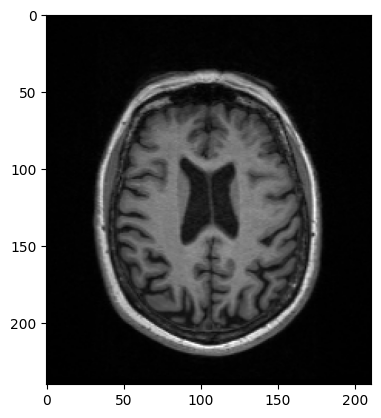

In [69]:
path = "dataset/ventricle_segmentation"
files = os.listdir(path)
plt.imshow(cv2.imread(path+ "/" + files[0]))

In [77]:
def get_mask(img):
    # Convert to Grayscale and filter out pixels between 18 and 40
    img_mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_mask = cv2.inRange(img_mask, 18, 40)

    # Apply morphological operations to remove noise
    img_mask = applyOpening(img_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    # Find contours and filter out small contours
    contours, _ = cv2.findContours(img_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    good = [cntr for cntr in contours if cv2.contourArea(cntr) > 40]

    # Draw contours and fill in the contours
    new_mask = cv2.drawContours(np.zeros(img_mask.shape, np.uint8), good, -1, (255,255,255), thickness=cv2.FILLED)

    # Apply morphological operations to remove noise
    img_mask = applyErode(new_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    return img_mask

def get_distance_mask(mask, threshold = 80):
    # find the center of the image
    image_height, image_width = mask.shape[:2]
    center_x = image_width//2.
    center_y = image_height//2.

    # calculate the distance from the center of the image
    distances = np.sqrt((np.arange(image_height)[:, np.newaxis] - center_y)**2 + (np.arange(image_width)[np.newaxis, :] - center_x)**2)

    # return a boolean mask of pixels within the threshold distance
    return distances < threshold

def label_mask(mask, distance_from_center_threshold = 60):
    # Create a zero array with the same shape as the mask
    label_mask = np.zeros_like(mask)

    # Set the propable background labels
    label_mask[mask == 0] = cv2.GC_PR_BGD

    # Get distance mask
    in_distance_flag = get_distance_mask(mask, distance_from_center_threshold)

    # Set the propable foreground labels if they are within the distance threshold else set them to foreground
    label_mask[(mask == 255) & in_distance_flag] = cv2.GC_FGD
    label_mask[(mask == 255) & ~in_distance_flag] = cv2.GC_PR_FGD

    return label_mask

def grabcut(img, label_mask):
    # Apply grabcut
    mask, bgdModel, fgdModel = cv2.grabCut(img=img,
                                           mask=label_mask,
                                           rect=None,
                                           bgdModel=np.zeros((1,65),np.float64),
                                           fgdModel=np.zeros((1,65),np.float64),
                                           iterCount=10,
                                           mode=cv2.GC_INIT_WITH_MASK)
    return mask


In [78]:
images = [cv2.imread(path+ "/" + file) for file in files]
masks = [get_mask(image.copy()) for image in images]
labeled_mask = [label_mask(mask.copy(), 40) for mask in masks]
grabcuts = [grabcut(image.copy(), label.copy()) for image, label in zip(images, labeled_mask)]

On the visualization below we can see the original image, the mask, the label and the result of the grabcut algorithm. From the mask we can tell that we were not able to select good foreground pixels for segmentation and that there were lot of background pixels. But at labeling phase we decided to use distance threshold to middle of image and label futher pixels as propable foreground instead foreground. With this method grabcut could decide, which pixels are foreground and which are background.

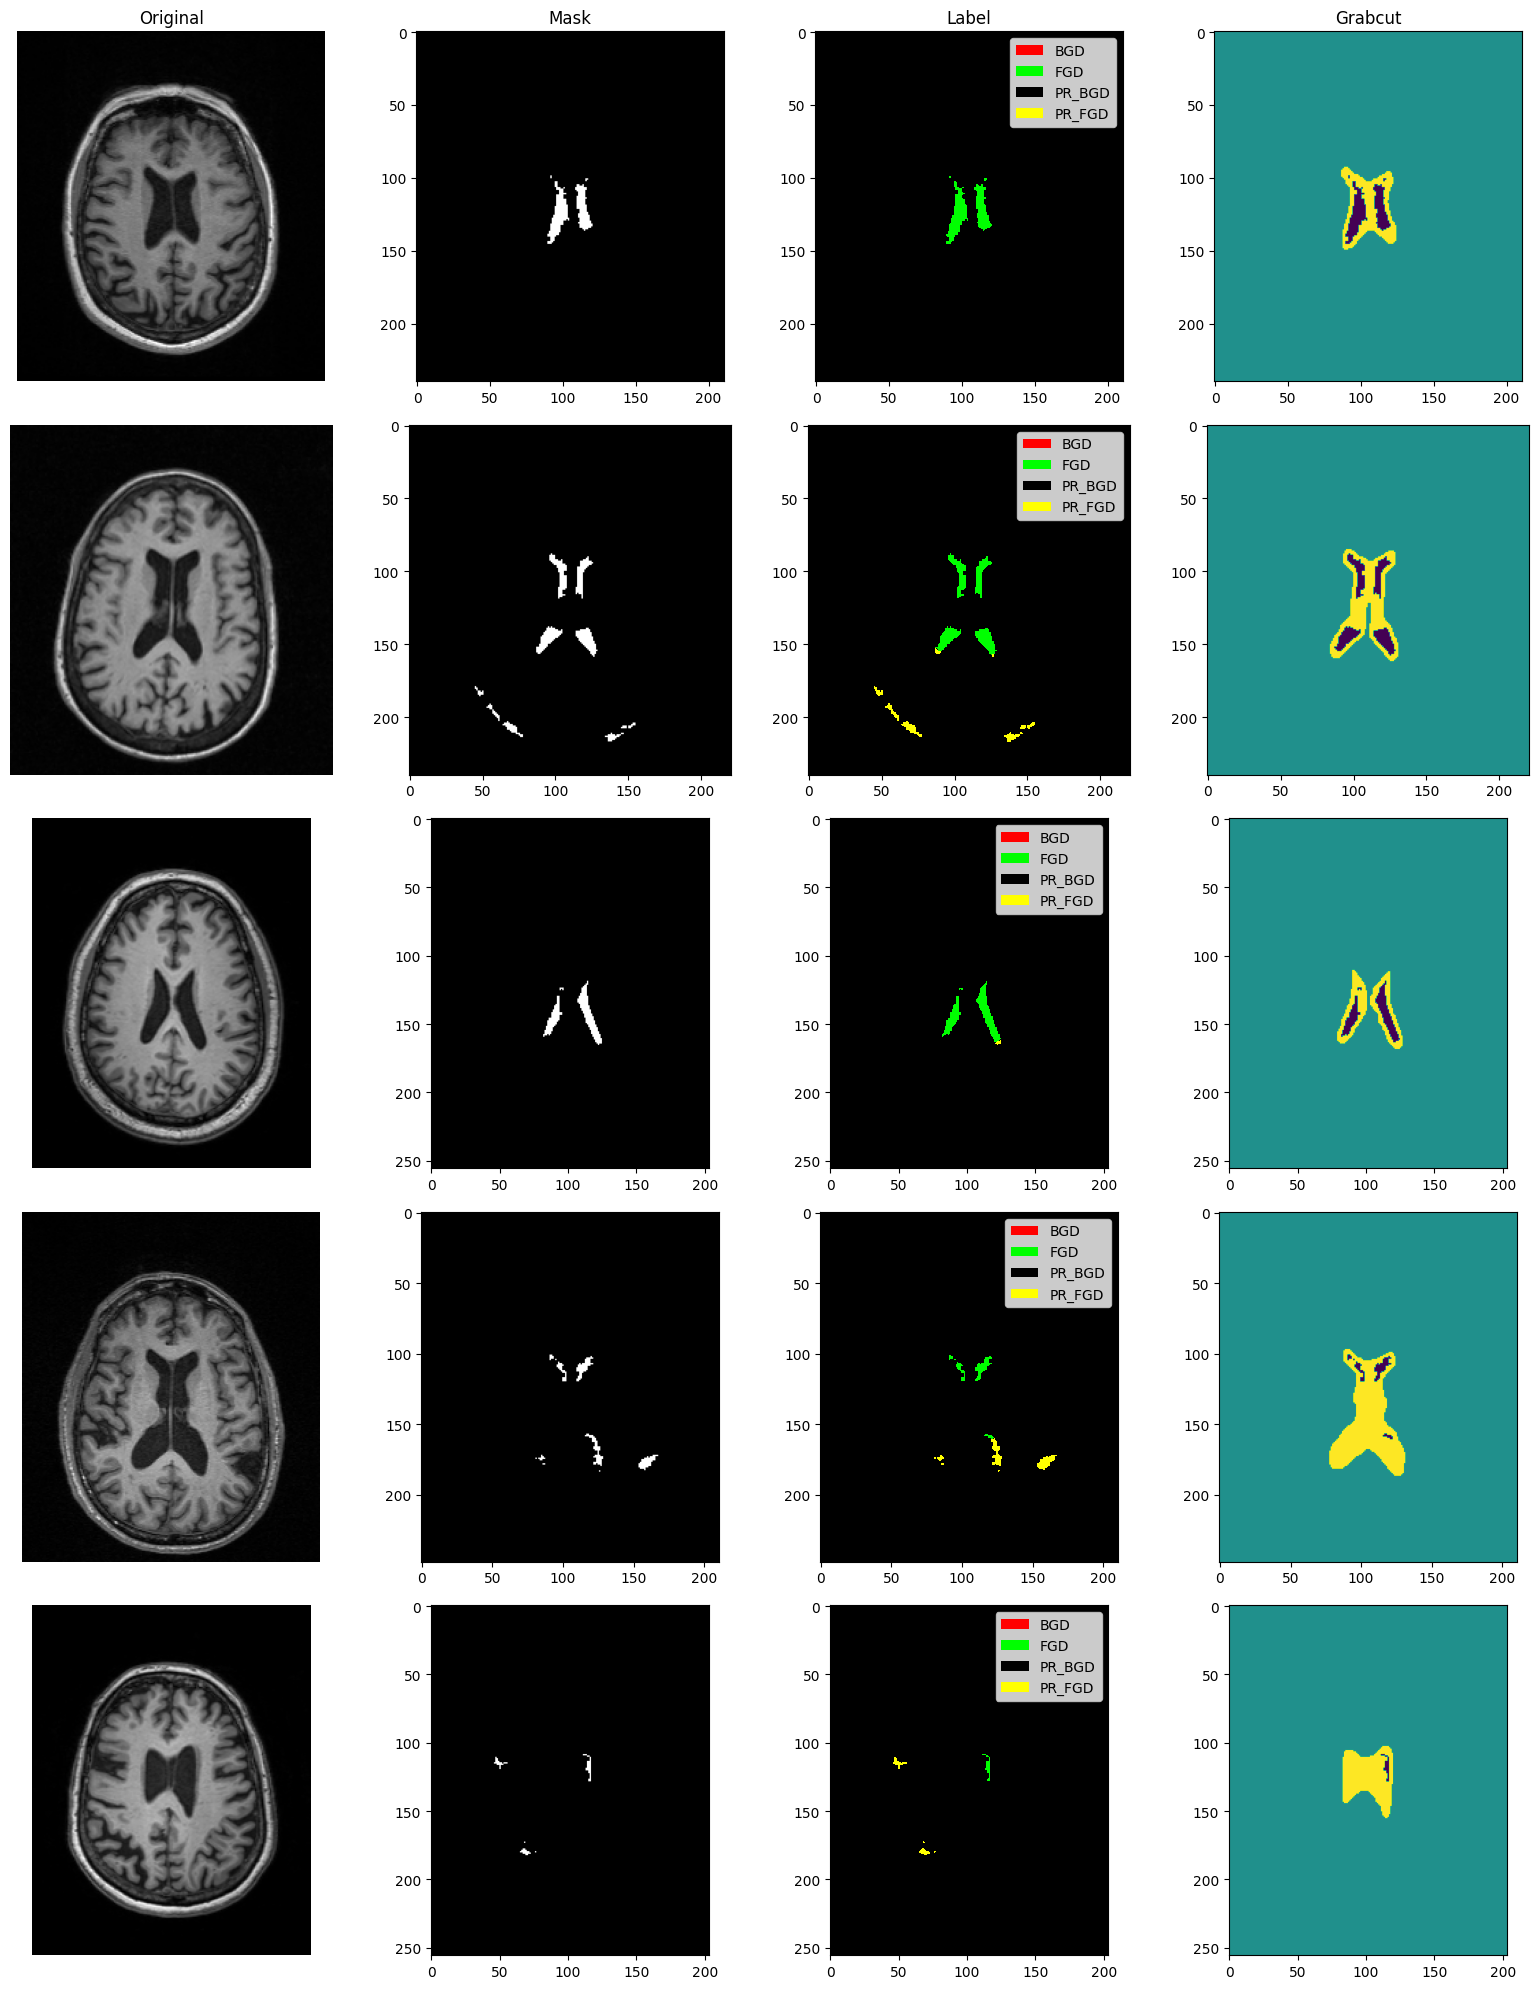

In [79]:
from matplotlib.colors import ListedColormap
fig, axes = plt.subplots(nrows=len(images), ncols=4, figsize=(16,20))
cmap = ListedColormap(['#FF0000', '#00FF00', '#000000', '#FFFF00'])

label_dict = {
    cv2.GC_BGD: "BGD",
    cv2.GC_FGD: "FGD",
    cv2.GC_PR_BGD: "PR_BGD",
    cv2.GC_PR_FGD: "PR_FGD"
}

axes[0][0].set_title("Original")
axes[0][1].set_title("Mask")
axes[0][2].set_title("Label")
axes[0][3].set_title("Grabcut")

for i, ax in enumerate(axes):
    handles = []
    for label_idx, label_name in label_dict.items():
        handles.append(plt.Rectangle((0, 0), 1, 1, fc=cmap(label_idx)))

    ax[0].imshow(images[i])
    ax[0].axis('off')
    ax[1].imshow(masks[i], cmap="gray")
    ax[2].imshow(labeled_mask[i], cmap=cmap, vmin=0, vmax=len(label_dict) - 1, alpha=1)
    ax[2].legend(handles, label_dict.values(), loc='upper right')
    ax[3].imshow(grabcuts[i])

plt.tight_layout()
plt.show()